# Evaluate Combined Segmentations of TotalSegmentator and MRSegmentator
TotalSegmentator was trained on the TotalSegmentator Dataset (CT-scans).
MRSegementator was trained on the Charité Dataset (MRI-scans).

This notebook tries to answer the following questions:
1. Which baseline performance can we expect of using TotalSegmentator & MRSegmentator on MRI?
2. Can we combine both models and use the predictions for self-supervised learning?
3. Can we utilize an active learning startegy to improve self-supverised learning process / annotation efficiency?

I will evaluate the baseline methods on a view already annotaded dixon scans of UKBB.
As an evaluation metrics I use the dice coefficient

In [123]:
import os
from tqdm.notebook import tqdm
from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Spacing,
    Lambda,
)
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    MapLabelValued,
    Lambdad,
    Compose,
    AsDiscreted,
    Spacingd,
)
from monai.metrics import DiceMetric
import pandas as pd
from scipy.stats import spearmanr
import json
import matplotlib.pyplot as plt

# private libraries
import sys

if "../scripts" not in sys.path:
    sys.path.insert(1, "../scripts")
import config
import labelmappings as lm

In [28]:
transforms = lambda labelmapper: Compose(
    [
        LoadImaged(keys=["pred", "label"], image_only=True),
        EnsureChannelFirstd(keys=["pred", "label"]),
        Spacingd(
            keys=["pred", "label"],
            pixdim=[3, 3, 3],
            mode="nearest",
        ),
        MapLabelValued(
            keys=["pred"],
            orig_labels=labelmapper.keys(),
            target_labels=labelmapper.values(),
            dtype=int,
        ),
        AsDiscreted(keys=["pred", "label"], to_onehot=41),
        Lambdad(keys=["pred", "label"], func=lambda x: x.unsqueeze(0)),
    ]
)

## Calculate Dice Scores

In [80]:
# List of annotated and segmented scans
annotated_files = [
    f.name for f in os.scandir(config.ukbb + "annotations") if f.name[-7:] == ".nii.gz"
]
annotated_files.sort()
data = pd.DataFrame()
data["label"] = annotated_files
data["section"] = data["label"].apply(lambda x: int(x.split("_")[1][-1]))


def add_type(df, _type):
    df["dixon_type"] = _type
    return df.copy()


data = pd.concat(
    [
        add_type(data, "W"),
        add_type(data, "F"),
        add_type(data, "in"),
        add_type(data, "opp"),
    ]
).reset_index(drop=True)

data["pred"] = data.apply(lambda row: row["label"].replace("W", row["dixon_type"]), axis=1)

In [83]:
data_list_total = [
    {
        "pred": config.ukbb + "preds_total/" + row["pred"],
        "label": config.ukbb + "annotations/" + row["label"],
    }
    for _, row in data.iterrows()
]

data_list_mr = [
    {
        "pred": config.ukbb + "preds_mr2/" + row["pred"],
        "label": config.ukbb + "annotations/" + row["label"],
    }
    for _, row in data.iterrows()
]

In [84]:
# Calculate dice
with open("../metadata/updated_metadata.json") as f:
    metadata = json.load(f)
channels = list(metadata["network_data_format"]["outputs"]["pred"]["channel_def"].values())[1:]
dice_metric = DiceMetric(include_background=False, reduction="none", num_classes=41)


def add_meta(df):
    df["section"] = data["section"]
    df["dixon_type"] = data["dixon_type"]
    return df


# TotalSegmentator
dice_metric.reset()
for item in tqdm(data_list_total):
    _item = transforms(lm.total2new)(item)
    dice_metric(_item["pred"], _item["label"])
scores_total = pd.DataFrame(dice_metric.get_buffer(), columns=channels)
scores_total = add_meta(scores_total)
scores_total["mean"] = list(scores_total.mean(axis=1))

# MRSegmentator
dice_metric.reset()
for item in tqdm(data_list_mr):
    _item = transforms(lm.mr2new)(item)
    dice_metric(_item["pred"], _item["label"])
scores_mr = pd.DataFrame(dice_metric.get_buffer(), columns=channels)
scores_mr = add_meta(scores_mr)
scores_mr["mean"] = list(scores_mr.mean(axis=1))

  0%|          | 0/372 [00:00<?, ?it/s]

## Compare Dice of different sequence types:
- Only compare dice of classes that are covered by both models
- MRSegmentator was mostly trained on data similar to section 2, its unlikely to work on other sections

In [110]:
shared_classes = [channels[i - 1] for i in list(lm.mr2new.values())[1:]]

print("Sequence \t TotalSeg \t MRSeq")
for seq in ["W", "F", "in", "opp"]:
    mean_total = (
        scores_total.loc[(data["section"] == 2) & (data["dixon_type"] == seq)][shared_classes]
        .mean()
        .mean()
    )
    mean_mr = (
        scores_mr.loc[(data["section"] == 2) & (data["dixon_type"] == seq)][shared_classes]
        .mean()
        .mean()
    )

    print(f"{seq} \t\t {mean_total:.3f} \t\t {mean_mr:.3f}")

Sequence 	 TotalSeg 	 MRSeq
W 		 0.772 		 0.649
F 		 0.046 		 0.468
in 		 0.082 		 0.531
opp 		 0.365 		 0.532


##### ==> Both models perform best on water only sequences. Consequently, I will focus on only this type of dixon sequences in the following work.

## Compare dice of models

In [115]:
scores_all = pd.DataFrame(index=channels + ["mean"])
scores_all["MRSeg"] = scores_mr.loc[data["dixon_type"] == "W"].mean(numeric_only=True)
scores_all["TotalSeg"] = scores_total.loc[data["dixon_type"] == "W"].mean(numeric_only=True)
scores_all

,MRSeg,TotalSeg
spleen,0.825775,0.987942
right_kidney,0.710431,0.961463
left_kidney,0.734384,0.980585
gallbladder,0.550029,0.159216
liver,0.798552,0.984348
stomach,0.611308,0.861766
pancreas,0.612155,0.893635
right_adrenal_gland,0.464298,0.739766
left_adrenal_gland,0.519871,0.706952
left_lung,0.000000,0.830875


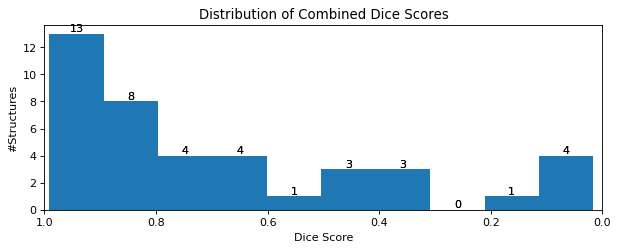

In [116]:
scores_all["Combined"] = scores_all.max(axis=1)
plt.figure(figsize=(9, 3), dpi=80)
counts, edges, bars = plt.hist(list(scores_all["Combined"]))
plt.bar_label(bars)
plt.xlim(1.0, 0)
plt.xlabel("Dice Score")
plt.ylabel("#Structures")
plt.title("Distribution of Combined Dice Scores")
plt.bar_label(bars)
plt.show()

## Is there a correlation between segmentation volume and Dice coefficient?
Section one to three have different base volumes, therefore I test correlation for all sections separetly. To reduce the effect of outliers I use spearmans correlation factor.

In [132]:
# Meassure Volume
calc_volume = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Spacing(pixdim=[3, 3, 3]),
        Lambda(func=lambda x: (x != 0).sum().item()),
    ]
)

volume_sec1 = [
    calc_volume(config.ukbb + "preds_combined/" + file)
    for file in data.loc[(data["section"] == 1) & (data["dixon_type"] == "W")]["pred"]
]
volume_sec2 = [
    calc_volume(config.ukbb + "preds_combined/" + file)
    for file in data.loc[(data["section"] == 2) & (data["dixon_type"] == "W")]["pred"]
]
volume_sec3 = [
    calc_volume(config.ukbb + "preds_combined/" + file)
    for file in data.loc[(data["section"] == 3) & (data["dixon_type"] == "W")]["pred"]
]

In [140]:
# Test correlation
print(
    spearmanr(
        volume_sec1, scores_total.loc[(data["section"] == 1) & (data["dixon_type"] == "W")]["mean"]
    )
)
print(
    spearmanr(
        volume_sec2, scores_total.loc[(data["section"] == 2) & (data["dixon_type"] == "W")]["mean"]
    )
)
print(
    spearmanr(
        volume_sec3, scores_total.loc[(data["section"] == 3) & (data["dixon_type"] == "W")]["mean"]
    )
)

SignificanceResult(statistic=0.517741935483871, pvalue=0.0028534156721904207)
SignificanceResult(statistic=0.7169354838709678, pvalue=5.693436391383669e-06)
SignificanceResult(statistic=0.1866935483870968, pvalue=0.31459517166493095)


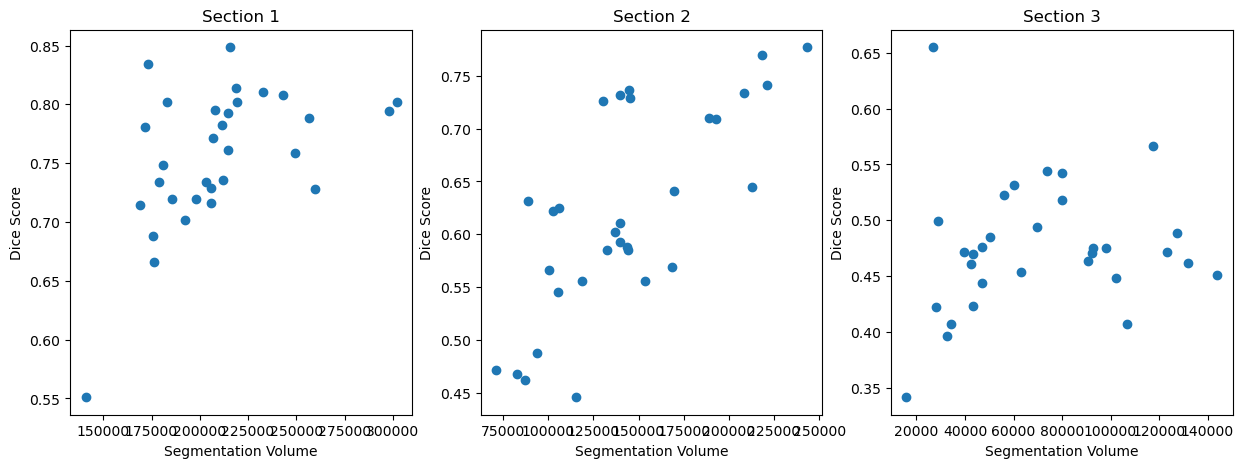

In [161]:
plt.subplot(1, 3, 1)
plt.scatter(
    volume_sec1, scores_total.loc[(data["section"] == 1) & (data["dixon_type"] == "W")]["mean"]
)
plt.xlabel("Segmentation Volume")
plt.ylabel("Dice Score")
plt.title("Section 1")

plt.subplot(1, 3, 2)
plt.scatter(
    volume_sec2, scores_total.loc[(data["section"] == 2) & (data["dixon_type"] == "W")]["mean"]
)
plt.xlabel("Segmentation Volume")
plt.ylabel("Dice Score")
plt.title("Section 2")

plt.subplot(1, 3, 3)
plt.scatter(
    volume_sec3, scores_total.loc[(data["section"] == 3) & (data["dixon_type"] == "W")]["mean"]
)
plt.xlabel("Segmentation Volume")
plt.ylabel("Dice Score")
plt.title("Section 3")

plt.gcf().set_size_inches((15, 5))
plt.show()

##### ==> There is strong correlation between segmentation volume and dice coefficient, espacially for sections 1 and 2.
I suspect this is because TotalSegmentator's specificity is higher than its sensitivity. It more often overlooks targets instead of misclassifying them.
It might increase the success of a self-supervised learning strategy if we exclude data with scans with low segmetnation volume, as they are more likely to be incorrect.